## Example

In [1]:
pip install lightkurve  --quiet 

Note: you may need to restart the kernel to use updated packages.


In [2]:
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy import table
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from copy import deepcopy
import lightkurve as lk
from xml.etree import ElementTree as ET
import json
import sys
import numpy as np
import pandas as pd
import requests
from six.moves import urllib
from sklearn.preprocessing import MinMaxScaler,StandardScaler, normalize, RobustScaler 
from sklearn import preprocessing
import pywt
from scipy import interpolate

In [5]:
lk.search_lightcurve('tic 14344979', author='SPOC')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 35,2021,SPOC,20,14344979,0.0
1,TESS Sector 35,2021,SPOC,120,14344979,0.0
2,TESS Sector 45,2021,SPOC,120,14344979,0.0
3,TESS Sector 46,2021,SPOC,120,14344979,0.0
4,TESS Sector 72,2023,SPOC,120,14344979,0.0


16% (2634/16780) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
1% (186/17256) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
2% (387/18539) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
0% (21/17839) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

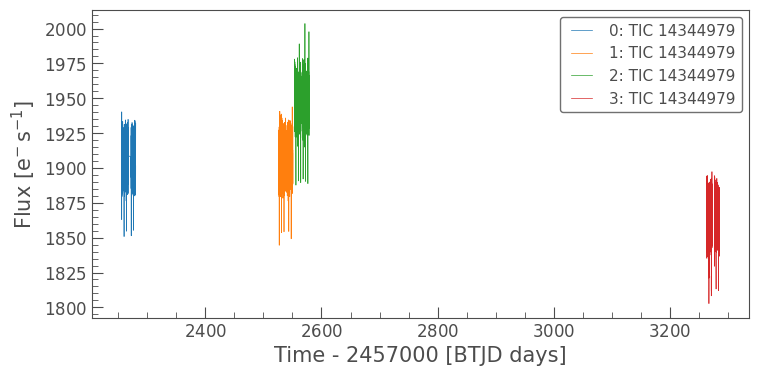

In [54]:
lk.search_lightcurve('tic 14344979', author='SPOC',exptime=120).download_all().plot()

In [55]:
def wave6(x1):
    ca1, cd1 = pywt.dwt(x1, 'bior6.8', 'per')    # dwt
    ca2, cd2 = pywt.dwt(ca1, 'bior6.8', 'per')  
    ca3, cd3 = pywt.dwt(ca2, 'bior6.8', 'per')  
    ca4, cd4 = pywt.dwt(ca3, 'bior6.8', 'per')  
    ca5, cd5 = pywt.dwt(ca4, 'bior6.8', 'per') 
    ca6, cd6 = pywt.dwt(ca5, 'bior6.8', 'per')  
    
    return ca6, cd6

In [56]:
pdcflux = []

lcs = lk.search_lightcurve('tic 14344979', author='SPOC',exptime=120, sector=[35,45,46,72]).download_all()
lcsN = lcs.stitch().remove_nans().flux.value
check = len(lcs)
if check<2:
    ca6, cd6 = wave6(lcsN)
    pdcflux.append([ca6, cd6])
else:
    redata = np.array([np.mean(lcsN[i:i+2]) for i in range(0, len(lcsN), 2)])  # By taking the average of two points, the dimension will reduce by half to 500
    ca6, cd6 = wave6(redata)
    pdcflux.append([ca6, cd6])

16% (2634/16780) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
1% (186/17256) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
2% (387/18539) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
0% (21/17839) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


In [57]:
def interp(x):

    t = np.arange(0,len(x))
    tn =  np.linspace(0, len(x), 510) 
    f = interpolate.interp1d(t, x, kind='quadratic',bounds_error=False) 
    xnew = f(tn)
    
    return xnew[5:505]  

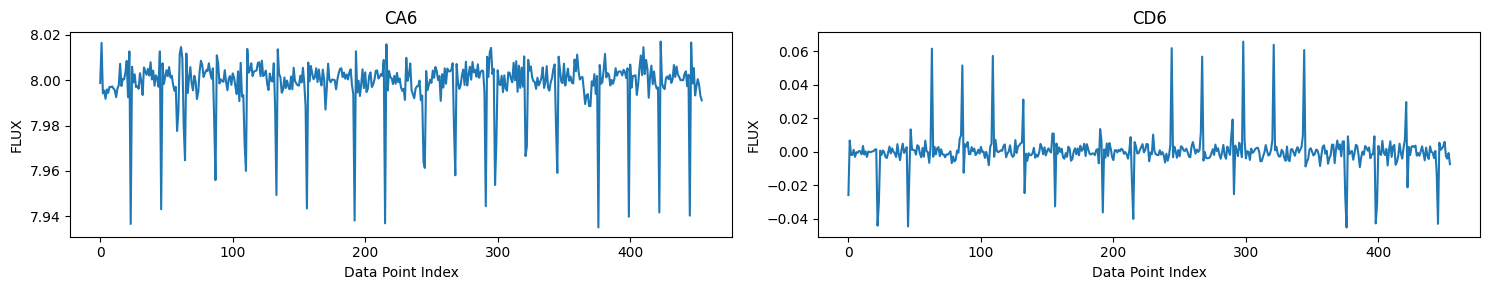

In [58]:
fig = plt.figure(figsize=(15,3))

ax = fig.add_subplot(1, 2, 1)  
ax.plot(pdcflux[0][0]) 
ax.set_title('CA6')
ax.set_xlabel('Data Point Index')
ax.set_ylabel('FLUX')
plt.tight_layout() 

ax = fig.add_subplot(1, 2, 2)  
ax.set_title('CD6')
ax.set_xlabel('Data Point Index')
ax.set_ylabel('FLUX')
ax.plot(pdcflux[0][1]) 
plt.tight_layout() 

In [59]:
lstca = [] 
lstcd = [] 
lstca.append([x[0] for x in pdcflux])
lstcd.append([x[1] for x in pdcflux])

In [60]:
def reshape500(lcs):

    res = []

    for i in range(len(lcs)):

        if len(lcs[i]) > 1000:
            data = lcs[i][:1000]  # only need 1000 points
            redata = np.array([np.mean(data[i:i+2]) for i in range(0, len(data), 2)])  # By taking the average of two points, the dimension will reduce by half to 500

        elif len(lcs[i]) > 500:
            redata = lcs[i][:500]  # only need 500 points

        else:
            redata = interp(lcs[i])  # interpolate

        res.append(redata)
        
    print(len(res))
    return res

In [61]:
ca500 = reshape500(lstca[0])
cd500 = reshape500(lstcd[0])

1
1


In [62]:
# minmax  Normalized

mmca =[]
mmcd =[]
for i in range(len(ca500)):
    
    if (ca500[i].max() - ca500[i].min()) != 0 and (cd500[i].max() - cd500[i].min()) != 0:

        cam = (ca500[i] - ca500[i].min()) / (ca500[i].max() - ca500[i].min())
        cdm = (cd500[i] - cd500[i].min()) / (cd500[i].max() - cd500[i].min())

        mmca.append(cam)
        mmcd.append(cdm)

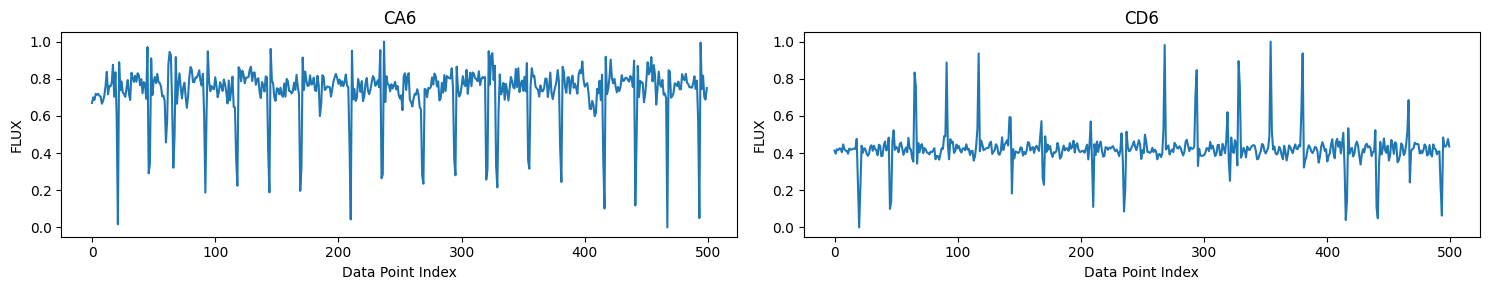

In [63]:
fig = plt.figure(figsize=(15,3))

ax = fig.add_subplot(1, 2, 1)  
ax.plot(mmca[0])  
ax.set_title('CA6')
ax.set_xlabel('Data Point Index')
ax.set_ylabel('FLUX')

ax = fig.add_subplot(1, 2, 2)  
ax.plot(mmcd[0])  
ax.set_title('CD6')
ax.set_xlabel('Data Point Index')
ax.set_ylabel('FLUX')
plt.tight_layout() 

Now, the original light curve has been wavelet decomposed, and both ca6 and cd6 have reached 500 points in length